In [4]:
import os
import random as rnd
import numpy as np
import pandas as pd
import peakutils
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
image_formats = set(["png", "jpg", "tif", "tiff"])

def get_coords(cnt):
    x, y = cnt.T[0][0], cnt.T[1][0]
    histx, binsx = np.histogram(x, bins=max(x)-min(x));
    indsx = peakutils.indexes(histx, min_dist=3, thres=0.3)
    if len(indsx) > 2:
        new = sorted(indsx, key=lambda i: histx[i])
        indsx = np.array(new[-2:])
        
    histy, binsy = np.histogram(y, bins=max(y)-min(y));
    indsy = peakutils.indexes(histy, min_dist=3, thres=0.3)
    if len(indsy) > 2:
        new = sorted(indsy, key=lambda i: histy[i])
        indsy = np.array(new[-2:])
        
    if len(indsx) < 2 or len(indsy) < 2:
        return None    
    return np.array([binsx[indsx[1]] + binsx[indsx[0]], binsy[indsy[1]] + binsy[indsy[0]]], dtype='int64') // 2    


def addpic(path, sup_path, p0, step, annotation): 
    '''
    p0 - coords of left bottom cross on image (in um)
    step - step in um from bottom left cross to the top right
    suppose that crosses are vertexes of rectangle
    '''
#     coordinates in microns - new points
    i = np.array([1, 0])
    j = np.array([0, 1])
    new_pts = np.array([p0, p0 + step*i, p0 + step*j, p0 + step])
    
#     coordinats in pixels - old points
    old_pts = []
    orig_img = cv.imread(path)
    size_thres = min(orig_img.shape[:1]) * 0.06
    
    if sup_path is not None:
        img = cv.imread(sup_path)
        size_thres /= 2
    else:
        img = orig_img
        
    if annotation is not None:
        img = img[:int(img.shape[0] * (1 - annotation))]
        
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    equ = cv.equalizeHist(gray)
    _, thresh = cv.threshold(equ, 100, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    kernel = np.ones((2, 2),np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)
    _, contours, hierarchy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)
        if w > size_thres and h > size_thres:
            M = cv.moments(cnt)
            centroid = np.array([int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])])                
            bbox_center = np.array([x + w / 2, y + h / 2])
            center = get_coords(cnt)
            if center is not None:
                if w / h < 1.2 and w / h > 0.8 and np.linalg.norm(centroid - center) < 0.15 * w and\
                    np.linalg.norm(centroid - bbox_center) < 0.15 * w or sup_path is not None:
                    cv.rectangle(orig_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
                    color = (rnd.randint(0, 256), rnd.randint(0, 256), rnd.randint(0, 256))
                    cv.drawContours(orig_img, [cnt], 0, color, 3, cv.LINE_8, hierarchy, 0)
                    cv.circle(orig_img, tuple(center), 5, (0, 0, 255), -1)
                    old_pts.append([center[0] - img.shape[0]/2, -center[1] + img.shape[1]/2])
                    
    old_pts = np.array(sorted(old_pts, key=lambda p: 2*np.sign(p[1]) + np.sign(p[0])))
    if len(old_pts) != 4:
        return None
    
    df = pd.DataFrame([[path] + list(old_pts.flatten()) + list(new_pts.flatten())])
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    ax.imshow(orig_img, interpolation='none', cmap='gray');
    return df


def add_images(dirname, offset=np.array([0, 0]), macrostep=np.array([0, 0]), step=np.array([0, 0]),\
               infield_shifts=np.array([np.array([0, 0]), np.array([0, 0])]), annotation=None,\
               multifields=True):
    
    full_df = pd.DataFrame()
    
    for i in os.listdir(dirname):
        path = os.path.join(dirname, i)
        if os.path.isfile(path):       
            parts = i.split('.')
            if parts[-1] not in image_formats:
                continue
            name = ".".join(parts[0:-1]).split('_')
            
            if len(name) >= 3 and not multifields:
                if name[-3][:-1] != "f" and name[-3][:-1] != "F" and name[-3][:-1] != "field":
                    print("Supposedly auxillary image", i, "was not inserted")
                    continue 
                field = int(name[-3][-1])            
                shift = macrostep * np.array([(field - 1) % 2, (field - 1) // 2])
                infield_shift = infield_shift[0]
                
            elif len(name) >= 4 and multifields:
                if name[-4][:-1] != "f" and name[-4][:-1] != "F" and name[-4][:-1] != "field":
                    print("Supposedly auxillary image", i, "was not inserted")
                    continue  
                field = int(name[-4][-1])
                infield = name[-3]
                shift = macrostep * np.array([(field-1) % 2, (field-1) // 2])
                if infield == 'r':
                    infield_shift = infield_shifts[1]
                elif infield == 'l':
                    infield_shift = infield_shifts[0]
                else:
                    print("Wrong filename. Image", i, "was not inserted")
                    continue            
            
            else:
                print("Wrong filename. Image", i, "was not inserted")
                continue
            p0 = offset + shift + infield_shift + np.array([int(name[-2])-1, int(name[-1])-1]) * step
            sup_path = os.path.join(dirname, '_'.join(name) + '_sup.' + parts[-1])
            if not os.path.isfile(sup_path):
                sup_path = None
            
            df = addpic(path, sup_path, p0, step, annotation)
            if df is None:
                print("Cannot find 4 crosses in", i)
                continue
                
            full_df = full_df.append(df)
            
    
    full_df.to_csv(os.path.join(dirname, "info.csv"), header=None, index=False)
    return full_df

Supposedly auxillary image SWCNT_29.05.2018_A_f1_r_2_2_sup.png was not inserted
Supposedly auxillary image SWCNT_29.05.2018_A_f2_l_2_2_sup.png was not inserted
Cannot find 4 crosses in SWCNT_29.05.2018_A_f4_r_3_2.png
Cannot find 4 crosses in SWCNT_29.05.2018_A_f1_l_2_2.png
Supposedly auxillary image SWCNT_29.05.2018_A_f2_r_2_2_sup.png was not inserted


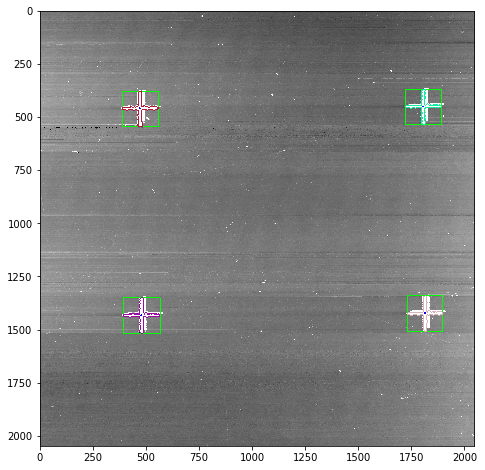

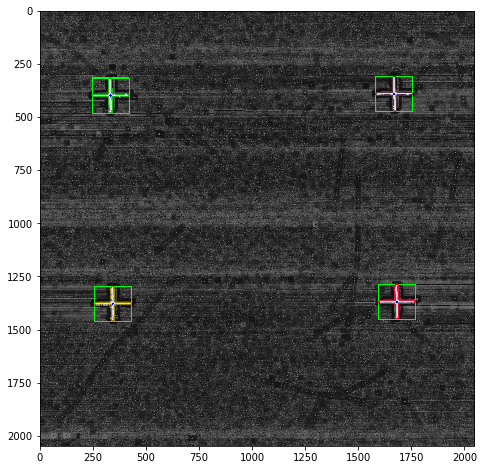

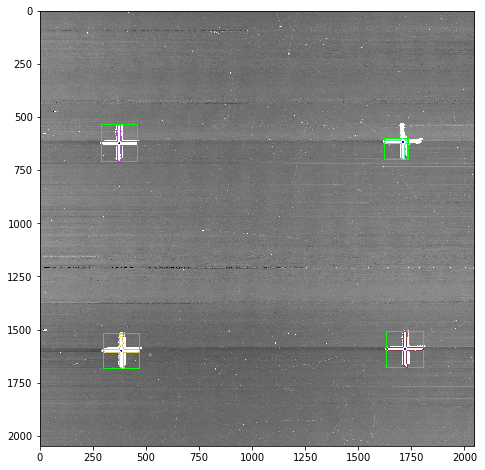

In [8]:
dirname = "/home/wobbuuu/Cloud_mail.ru/Working Folder/Equipment PC/Brueker Multimode V8 (Skoltech)/10.01 SWCNT_29.05.2018_A_localization/export"

# Old designs with multifields
# df = add_images(dirname, offset=np.array([300, 300]), macrostep=np.array([1800, 1800]),\
#                 infield_shifts = np.array([[156, 276], [396, 276]]), step=np.array([16, 12]))

# New designs Eska 
df = add_images(dirname, offset=np.array([816, 816]), macrostep=np.array([1080, 1320]),\
                infield_shifts = np.array([[0, 0], [240, 0]]), step=np.array([16, 12]))

In [7]:
df = pd.read_csv(os.path.join(dirname, "info.csv"), header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,/home/wobbuuu/Cloud_mail.ru/Working Folder/Equ...,-547.0,-408.0,788.0,-399.0,-555.0,566.0,780.0,575.0,2512,588,2528,588,2512,600,2528,600
1,/home/wobbuuu/Cloud_mail.ru/Working Folder/Equ...,-682.0,-353.0,655.0,-345.0,-693.0,627.0,643.0,635.0,2272,588,2288,588,2272,600,2288,600
2,/home/wobbuuu/Cloud_mail.ru/Working Folder/Equ...,-641.0,-575.0,695.0,-567.0,-651.0,401.0,684.0,409.0,712,588,728,588,712,600,728,600
